In [1]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching galvani_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s galvani_Scene"

Manim Community v0.18.0.post0

Jupyter Capture Output v0.0.11


In [160]:
class Galvanometre(Mobject):
    def __init__(self, centre, radius, **kwargs):
        super().__init__(**kwargs)
        self.centre = centre
        self.radius = radius

        # circle with angels
        tick_width = 0.2
        angle_circle = Circle(radius = self.radius, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).move_to(centre)
        angle_circle_out = Circle(radius = self.radius+tick_width, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).move_to(centre)
        for i in range(8):
            angle = i*2*PI/8
            degree_angle = int(i/8*360)
            angle_tick = Line(start = centre+radius*UP, end = centre+(radius+tick_width)*UP, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).rotate(about_point = self.centre, angle = angle)
            angle_tick_descriptor = Text(f"{degree_angle}", color = BLACK, fill_opacity = 0.5, font_size = 20).move_to(self.centre + (self.radius+2.75*tick_width)*(UP*np.cos(angle) + LEFT*np.sin(angle)))
            self.add(angle_tick, angle_tick_descriptor)
        self.add(angle_circle, angle_circle_out)


    # returns the needle for a given angle in rad
    def get_needle(self, angle):
        base_width = 0.5
        top_width = 0.2
        needle_radius = 0.95
        
        # polygon edges
        base_left = self.centre + base_width/2*LEFT
        base_right = self.centre + base_width/2*RIGHT
        upper_left = self.centre + (needle_radius*self.radius)*UP + top_width/2*LEFT
        upper_right = self.centre + (needle_radius*self.radius)*UP + top_width/2*RIGHT
        lower_left = self.centre + (needle_radius*self.radius)*DOWN + top_width/2*LEFT
        lower_right = self.centre + (needle_radius*self.radius)*DOWN + top_width/2*RIGHT

        # lists of polygon edges
        top_position_list = [base_left, upper_left, upper_right, base_right]
        down_position_list = [base_left, lower_left, lower_right, base_right]
        # polygons
        upper_polygon = Polygon(*top_position_list, stroke_color = RED, fill_color = RED, fill_opacity = 0.5, stroke_opacity = 0)
        lower_polygon = Polygon(*down_position_list, stroke_color = BLUE, fill_color = GREEN, fill_opacity = 0.5, stroke_opacity = 0)

        # arcs
        arc_angle = 2*np.arcsin(top_width/2/needle_radius/self.radius)
        upper_arc = Arc(arc_center = self.centre, radius = needle_radius*self.radius, start_angle = PI/2-arc_angle/2, angle = arc_angle, fill_color = RED, stroke_color = BLACK, fill_opacity = 0.5, stroke_opacity = 0)
        lower_arc = Arc(arc_center = self.centre, radius = needle_radius*self.radius, start_angle = PI+PI/2-arc_angle/2, angle = arc_angle, fill_color = GREEN, stroke_color = BLACK, fill_opacity = 0.5, stroke_opacity = 0)
        return VGroup(upper_polygon, lower_polygon, upper_arc, lower_arc).rotate(about_point = self.centre, angle = angle)

Output saved by creating file at animations/galvanometre/galvanometre.mp4.


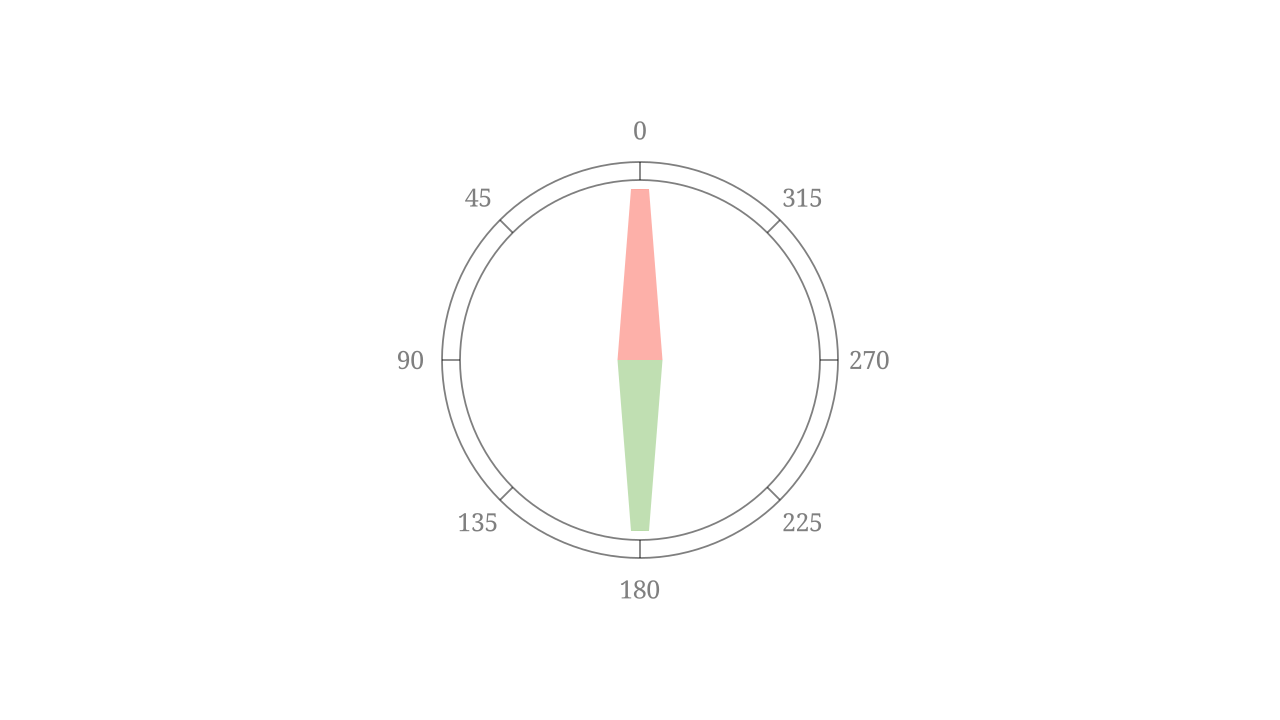

In [161]:
%%capture_video --path "animations/galvanometre/galvanometre.mp4"
%%manim -qm --fps 60 $video_scene


class galvani_Scene(Scene):
    def construct(self):
        self.camera.background_color = WHITE

        galvani_centre = np.array([0, 0, 0])

        galvanometre = Galvanometre(centre = galvani_centre, radius = 2)
        needle = galvanometre.get_needle(0)
        self.add(galvanometre, needle)